# Tone cluster audio waveform

Francis Deck, October 1, 2016

The MIT License (MIT)
Copyright (c) 2016 Francis Deck

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Overview

Common DIY approaches to PC based audio spectrum analysis are based on generation of random noise, processing through a device-under-test, and Fourier transform (FT) analysis of the resulting signal. 

A drawback to a random input is that the output of the analysis is also random, i.e., successive measurements will produce slightly different results: Measurements will seem erratic when displayed in real time. This variation can be reduced by averaging, but doing so works against real time analysis, by requiring many successive measurements in order to produce a stable display.

I've experimented with yet another approach, which is to generate an artificial signal that is broadband in its content, but definitely not random. In this notebook, the signal is a "tone cluster," or a summation of sinusoids at discrete frequencies. 

I've also chosen frequencies so that each individual tone comes out to an integer number of cycles within a "block" of data read by the analyzer, whose length is typically a power of two. Thus from the standpoint of Fourier analysis, each sinusoid behaves like a continuous tone. Analyzing this tone cluster requires no apodization or "window" function.

My method assumes that there's nothing of interest lurking between the generated frequencies, which is not always a good assumption, but works well enough for measuring things like the low frequency behavior of speakers, or the functioning of mainstream audio circuits.

### Intended audience

I'm assuming that you fall into one of the following three categories:

* You're familiar with Python and Jupyter, and using this code won't be hard for you, even if you have to install some of the libraries.

* You're interested in the underlying theory, in which case the code does a decent job of documenting it, even if you're not planning on running it yourself.

* You just want the files already.

### TL;DR, just give me the file already

The file **tonez44110.mp3** is what you need for mainstream PC use. I've found that compressing it to MP3 format has no adverse effect on audio analysis. You will need to set up your analyzer for a 44.1 kHz sampling rate, 16k block length, and no windowing function. Just play it using the MP3 player app on your computer.

### Preliminaries: Load Python libraries

If this step generates errors, then you have to install the missing libraries. I use a distribution called WinPython, which has all of the best-of libraries built in.

In [7]:
import math, numpy, numpy.random, numpy.fft, matplotlib.pyplot, wave
from __future__ import division, print_function
%matplotlib inline
from matplotlib.pyplot import *

### Configuration constants

In [8]:
block_length = 4096 # block length in units of samples for waveform, should be a power of 2
sample_rate = 44100 # sampling rate in samples/sec

tfile = 300 # Length of file in seconds
fmin = 10 # Minimum frequency we're interested in
fmax = 20000 # Maximum frequency we're interested in
ratio = 1.1 # Approximate ratio from one frequency to the next
fThresh = 100
ratio2 = 1.1

### Generate the list of frequencies that we will use. 

Each frequency is chosen so that the data block is an integer number of periods. The multiplier of 1.2 gives us a roughly 1/3 octave spacing with 16384 block length.

The idea is that every sinusoid begins and ends on a block boundary. Under this condition, the FFT analysis program can sample a block at any arbitrary time and compute the spectrum without any need for apodization. The arbitrary starting time translates into a constant amplitude but random phase.

In [14]:
j = math.ceil(fmin*block_length/sample_rate) # Starting frequency in cycles per block
fpos = [] # List of frequencies in cycles per block
f = [] # List of frequencies in Hz

while True:
    fpos.append(j)
    f.append(j*sample_rate/block_length) # Get this frequency
    fnext = f[-1]*ratio # Estimate the next frequency
    j = math.ceil(fnext*block_length/sample_rate); # Convert to next higher integer
    if fnext > fmax:
        break
        
print('index', 'cycles/block', 'freq (Hz)', sep = '\t')
for i in range(len(fpos)):
    print(i, fpos[i], f[i], sep = '\t')

index	cycles/block	freq (Hz)
0	1	10.7666015625
1	2	21.533203125
2	3	32.2998046875
3	4	43.06640625
4	5	53.8330078125
5	6	64.599609375
6	7	75.3662109375
7	8	86.1328125
8	9	96.8994140625
9	10	107.666015625
10	12	129.19921875
11	14	150.732421875
12	16	172.265625
13	18	193.798828125
14	20	215.33203125
15	23	247.6318359375
16	26	279.931640625
17	29	312.2314453125
18	32	344.53125
19	36	387.59765625
20	40	430.6640625
21	45	484.4970703125
22	50	538.330078125
23	55	592.1630859375
24	61	656.7626953125
25	68	732.12890625
26	75	807.4951171875
27	83	893.6279296875
28	92	990.52734375
29	102	1098.193359375
30	113	1216.6259765625
31	125	1345.8251953125
32	138	1485.791015625
33	152	1636.5234375
34	168	1808.7890625
35	185	1991.8212890625
36	204	2196.38671875
37	225	2422.4853515625
38	248	2670.1171875
39	273	2939.2822265625
40	301	3240.7470703125
41	332	3574.51171875
42	366	3940.576171875
43	403	4338.9404296875
44	444	4780.37109375
45	489	5264.8681640625
46	538	5792.431640625
47	592	6373.828125
48	652	701

Build array by summing sinusoids. Each gets a random phase, so there
is not a periodic "burst" at the start of every block.

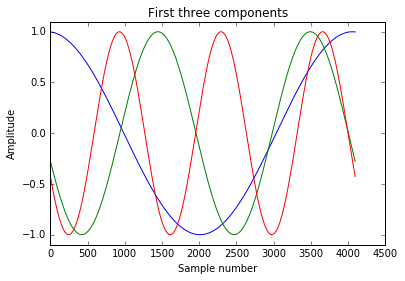

In [16]:
numpy.random.seed()
tblock = block_length/sample_rate
nblocks = math.ceil(tfile/tblock)

ts = 1/sample_rate # Time period of each sample
t = numpy.arange(0, tblock, ts, dtype = numpy.float) # Array of time values
a = numpy.zeros_like(t, dtype = numpy.float); # Start with a zeroed-out array

for i in range(len(f)):
    omega = 2*numpy.pi*f[i]
    phase = numpy.random.rand()*2*numpy.pi
    s = numpy.sin(omega*t + phase)
    a = a + s
    if i < 3: # show first three components
        plot(s)

title('First three components')
xlabel('Sample number')
ylabel('Amplitude')
gca().set_ylim(-1.1, 1.1)
show()

# Normalize to +/- 1, with an amplitude just shy of 32768

a = a*32000/max(abs(a))

## Plot FFT of first block

...just so we can check our work. The waveform will "look" random. The peaks of the spectrum should be roughly equally spaced, and of uniform height. Also, this is how it will look when measured with a FFT spectrum analyzer, if...

1. The sampling rate and block length for the spectrum analyzer are equal to the values chosen here.
2. No apodization or windowing, if possible. Set "windowing function" to "None."

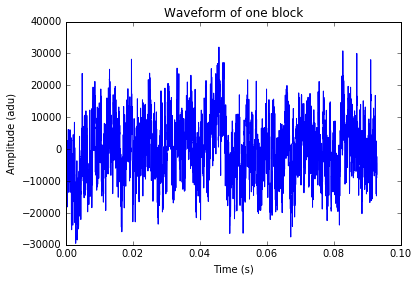

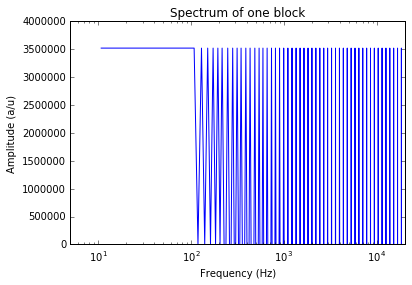

In [11]:
plot(t, a)
title('Waveform of one block')
xlabel('Time (s)')
ylabel('Amplitude (adu)')
show()
b = numpy.abs(numpy.fft.rfft(a))[:-1]
bt = numpy.linspace(0, sample_rate/2, block_length/2)
semilogx(bt, b)
gca().set_xlim(5, 20000)
title('Spectrum of one block')
xlabel('Frequency (Hz)')
ylabel('Amplitude (a/u)')
show()

## Write the .WAV file

Convert into integer format, use wave library to create .WAV file

In [12]:
aint = numpy.array(a, dtype = numpy.int16)

wf = wave.open('tonez44100.wav', 'wb')
wf.setnchannels(1) # number of channels, this will be monaural
wf.setsampwidth(2) # width of each sample, in bytes
wf.setframerate(int(sample_rate)) # intended sampling rate
for i in range(nblocks):
    wf.writeframes(aint)
wf.close()